# Convolutional Layers

In this lab you will implement convolutional layers in the MLP framework, and carry out some basic experiments to validate your implementation. 

We provide a convolutional layer skeleton as a class named `ConvolutionalLayer`. This class should implement the methods `fprop`, `bprop` and `grads_wrt_params`. There are two recommended approaches that you might consider to do the implementation (you can implement both or any one of these approaches), based on

* the methods scipy.signal.convolve2d (and/or scipy.signal.correlate2d);
* or using a "serialisation" approach using the method im2col.

Both of these approaches are discussed below.

Associated test functions for the `fprop`, `bprop` and `grads_wrt_params` methods of the ConvolutionalLayer class are included.

The test functions assume that in your implementation of `fprop` for the convolutional layer, outputs are calculated only for 'valid' overlaps of the kernel filters with the input - i.e. without any padding.

It is also assumed that if convolutions with non-unit strides are implemented the default behaviour is to take unit-strides, with the test cases only correct for unit strides in both directions.

When you implement a convolutional layer, both the `fprop` and `bprop` methods can be based on a convolution
operation, as explained in the lectures. If we consider the fprop then the method operates on two 4-dimension
tensors:
* The input (previous layer) to the convolution, whose dimensions are `(minibatch-size, num-feature-maps, xin, yin)`;
* The kernels (weight matrices) for the convolutions, whose dimensions are `(num-feature-maps-in, num-feature-maps-out, xkernel, ykernel)`.

The key to implementing a convolutional layer is how the convolutions are implemented. We recommend that
you consider one of the following approaches:

* Explicitly compute convolutions using the SciPy convolution function scipy.signal.convolve2d (or scipy.signal.correlate2d). Note that these functions convolve a 2-dimension image with a 2-dimension kernel, so your code will need to use this in the context of 4-dimension tensors where we have multiple feature maps and a batch of training examples.

* "Serialisation" in which the the convolution operation is turned into a single matrix multiplication. The advantage of this is that implementing the convolutional fprop or bprop as a single large matrix multiplication is much more computationally efficient than the many small matrix multiplications a naive implementation would have. The disadvantage of this approach is that the resultant matrix has repeated elements, and be large (dependent on the number of feature map, batch size, and image size). This serialisation approach uses a function called im2col (and its reverse col2im). The im2col function is standard in Matlab and various computer vision packages, but it is not part of NumPy or SciPy; you may use the external Python implementations im2col_indices and col2im_indices at:
https://github.com/huyouare/CS231n/blob/master/assignment2/cs231n/im2col.py

In [ ]:
import mlp.layers as layers
import mlp.initialisers as init

from scipy.ndimage.filters import convolve
from scipy.signal import convolve2d, correlate2d

class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
            num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape 
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
        """
        
        
        raise NotImplementedError()

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_input_channels, input_dim_1, input_dim_2).
        """
        
        raise NotImplementedError()

    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
        """
        
   
        raise NotImplementedError()

    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]

    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

The three test functions are defined in the cell below. All the functions take as first argument the *class* corresponding to the convolutional layer implementation to be tested (**not** an instance of the class). It is assumed the class being tested has an `__init__` method with at least all of the arguments defined in the skeleton definition above. A boolean second argument to each function can be used to specify if the layer implements a cross-correlation or convolution based operation (see notes in the elcture slides).

In [ ]:
import numpy as np

def test_conv_layer_fprop(layer_class, do_cross_correlation=False):
    """Tests `fprop` method of a convolutional layer.
    
    Checks the outputs of `fprop` method for a fixed input against known
    reference values for the outputs and raises an AssertionError if
    the outputted values are not consistent with the reference values. If
    tests are all passed returns True.
    
    Args:
        layer_class: Convolutional layer implementation following the 
            interface defined in the provided skeleton class.
        do_cross_correlation: Whether the layer implements an operation
            corresponding to cross-correlation (True) i.e kernels are
            not flipped before sliding over inputs, or convolution
            (False) with filters being flipped.

    Raises:
        AssertionError: Raised if output of `layer.fprop` is inconsistent 
            with reference values either in shape or values.
    """
    inputs = np.arange(96).reshape((2, 3, 4, 4))
    kernels = np.arange(-12, 12).reshape((2, 3, 2, 2))
    if do_cross_correlation:
        kernels = kernels[:, :, ::-1, ::-1]
    biases = np.arange(2)
    true_output = np.array(
        [[[[ -958., -1036., -1114.],
           [-1270., -1348., -1426.],
           [-1582., -1660., -1738.]],
          [[ 1707.,  1773.,  1839.],
           [ 1971.,  2037.,  2103.],
           [ 2235.,  2301.,  2367.]]],
         [[[-4702., -4780., -4858.],
           [-5014., -5092., -5170.],
           [-5326., -5404., -5482.]],
          [[ 4875.,  4941.,  5007.],
           [ 5139.,  5205.,  5271.],
           [ 5403.,  5469.,  5535.]]]]
    )
    
#     layer = layer_class(
#         num_input_channels=kernels.shape[1], 
#         num_output_channels=kernels.shape[0], 
#         input_height=inputs.shape[2], 
#         input_width=inputs.shape[3],
#         kernel_height=kernels.shape[2],
#         kernel_width=kernels.shape[3]
#     )
    layer = layer_class(
        kernels.shape[1], 
        kernels.shape[0], 
        inputs.shape[2], 
        inputs.shape[3],
        kernels.shape[2],
        kernels.shape[3]
    )
    layer.params = [kernels, biases]
    layer_output = layer.fprop(inputs)
    assert layer_output.shape == true_output.shape, (
        'Layer fprop gives incorrect shaped output. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_output.shape, layer_output.shape)
    )
    assert np.allclose(layer_output, true_output), (
        'Layer fprop does not give correct output. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}\n\n difference is \n\n{2}.'
        .format(true_output, layer_output, true_output-layer_output)
    )
    return True

def test_conv_layer_bprop(layer_class, do_cross_correlation=False):
    """Tests `bprop` method of a convolutional layer.
    
    Checks the outputs of `bprop` method for a fixed input against known
    reference values for the gradients with respect to inputs and raises 
    an AssertionError if the returned values are not consistent with the
    reference values. If tests are all passed returns True.
    
    Args:
        layer_class: Convolutional layer implementation following the 
            interface defined in the provided skeleton class.
        do_cross_correlation: Whether the layer implements an operation
            corresponding to cross-correlation (True) i.e kernels are
            not flipped before sliding over inputs, or convolution
            (False) with filters being flipped.

    Raises:
        AssertionError: Raised if output of `layer.bprop` is inconsistent 
            with reference values either in shape or values.
    """
    inputs = np.arange(96).reshape((2, 3, 4, 4))
    kernels = np.arange(-12, 12).reshape((2, 3, 2, 2))
    if do_cross_correlation:
        kernels = kernels[:, :, ::-1, ::-1]
    biases = np.arange(2)
    grads_wrt_outputs = np.arange(-20, 16).reshape((2, 2, 3, 3))
    outputs = np.array(
        [[[[ -958., -1036., -1114.],
           [-1270., -1348., -1426.],
           [-1582., -1660., -1738.]],
          [[ 1707.,  1773.,  1839.],
           [ 1971.,  2037.,  2103.],
           [ 2235.,  2301.,  2367.]]],
         [[[-4702., -4780., -4858.],
           [-5014., -5092., -5170.],
           [-5326., -5404., -5482.]],
          [[ 4875.,  4941.,  5007.],
           [ 5139.,  5205.,  5271.],
           [ 5403.,  5469.,  5535.]]]]
    )
    true_grads_wrt_inputs = np.array(
      [[[[ 147.,  319.,  305.,  162.],
         [ 338.,  716.,  680.,  354.],
         [ 290.,  608.,  572.,  294.],
         [ 149.,  307.,  285.,  144.]],
        [[  23.,   79.,   81.,   54.],
         [ 114.,  284.,  280.,  162.],
         [ 114.,  272.,  268.,  150.],
         [  73.,  163.,  157.,   84.]],
        [[-101., -161., -143.,  -54.],
         [-110., -148., -120.,  -30.],
         [ -62.,  -64.,  -36.,    6.],
         [  -3.,   19.,   29.,   24.]]],
       [[[  39.,   67.,   53.,   18.],
         [  50.,   68.,   32.,   -6.],
         [   2.,  -40.,  -76.,  -66.],
         [ -31.,  -89., -111.,  -72.]],
        [[  59.,  115.,  117.,   54.],
         [ 114.,  212.,  208.,   90.],
         [ 114.,  200.,  196.,   78.],
         [  37.,   55.,   49.,   12.]],
        [[  79.,  163.,  181.,   90.],
         [ 178.,  356.,  384.,  186.],
         [ 226.,  440.,  468.,  222.],
         [ 105.,  199.,  209.,   96.]]]])

    layer = layer_class(
        kernels.shape[1], 
        kernels.shape[0], 
        inputs.shape[2], 
        inputs.shape[3],
        kernels.shape[2],
        kernels.shape[3]
    )
    layer.params = [kernels, biases]
    layer_grads_wrt_inputs = layer.bprop(inputs, outputs, grads_wrt_outputs)
    assert layer_grads_wrt_inputs.shape == true_grads_wrt_inputs.shape, (
        'Layer bprop returns incorrect shaped array. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_grads_wrt_inputs.shape, layer_grads_wrt_inputs.shape)
    )
    assert np.allclose(layer_grads_wrt_inputs, true_grads_wrt_inputs), (
        'Layer bprop does not return correct values. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}\n\n difference is \n\n{2}'
        .format(true_grads_wrt_inputs, layer_grads_wrt_inputs, layer_grads_wrt_inputs-true_grads_wrt_inputs)
    )
    return True

def test_conv_layer_grad_wrt_params(
        layer_class, do_cross_correlation=False):
    """Tests `grad_wrt_params` method of a convolutional layer.
    
    Checks the outputs of `grad_wrt_params` method for fixed inputs 
    against known reference values for the gradients with respect to 
    kernels and biases, and raises an AssertionError if the returned
    values are not consistent with the reference values. If tests
    are all passed returns True.
    
    Args:
        layer_class: Convolutional layer implementation following the 
            interface defined in the provided skeleton class.
        do_cross_correlation: Whether the layer implements an operation
            corresponding to cross-correlation (True) i.e kernels are
            not flipped before sliding over inputs, or convolution
            (False) with filters being flipped.

    Raises:
        AssertionError: Raised if output of `layer.grad_wrt_params` is inconsistent 
            with reference values either in shape or values.
    """
    inputs = np.arange(96).reshape((2, 3, 4, 4))
    kernels = np.arange(-12, 12).reshape((2, 3, 2, 2))
    biases = np.arange(2)
    grads_wrt_outputs = np.arange(-20, 16).reshape((2, 2, 3, 3))
    true_kernel_grads = np.array(
        [[[[ -240.,  -114.],
         [  264.,   390.]],
        [[-2256., -2130.],
         [-1752., -1626.]],
        [[-4272., -4146.],
         [-3768., -3642.]]],
       [[[ 5268.,  5232.],
         [ 5124.,  5088.]],
        [[ 5844.,  5808.],
         [ 5700.,  5664.]],
        [[ 6420.,  6384.],
         [ 6276.,  6240.]]]])
    if do_cross_correlation:
        kernels = kernels[:, :, ::-1, ::-1]
        true_kernel_grads = true_kernel_grads[:, :, ::-1, ::-1]
    true_bias_grads = np.array([-126.,   36.])

    layer = layer_class(
        kernels.shape[1], 
        kernels.shape[0], 
        inputs.shape[2], 
        inputs.shape[3],
        kernels.shape[2],
        kernels.shape[3]
    )
    layer.params = [kernels, biases]
    layer_kernel_grads, layer_bias_grads = (
        layer.grads_wrt_params(inputs, grads_wrt_outputs))
    assert layer_kernel_grads.shape == true_kernel_grads.shape, (
        'grads_wrt_params gives incorrect shaped kernel gradients output. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_kernel_grads.shape, layer_kernel_grads.shape)
    )
    assert np.allclose(layer_kernel_grads, true_kernel_grads), (
        'grads_wrt_params does not give correct kernel gradients output. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}.'
        .format(true_kernel_grads, layer_kernel_grads)
    )
    assert layer_bias_grads.shape == true_bias_grads.shape, (
        'grads_wrt_params gives incorrect shaped bias gradients output. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_bias_grads.shape, layer_bias_grads.shape)
    )
    assert np.allclose(layer_bias_grads, true_bias_grads), (
        'grads_wrt_params does not give correct bias gradients output. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}.'
        .format(true_bias_grads, layer_bias_grads)
    )
    return True

An example of using the test functions if given in the cell below. This assumes you implement a convolution (rather than cross-correlation) operation. If the implementation is correct 

In [ ]:
# from mlp.layers import ConvolutionalLayer
fprop_correct = test_conv_layer_fprop(ConvolutionalLayer, False)
bprop_correct = test_conv_layer_bprop(ConvolutionalLayer, False)
grads_wrt_param_correct = test_conv_layer_grad_wrt_params(ConvolutionalLayer, False)
if fprop_correct and grads_wrt_param_correct and bprop_correct:
    print('All tests passed.')

In [ ]:
import matplotlib.pyplot as plt
import logging
from mlp.layers import ReluLayer, ReshapeLayer, AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import UniformInit, ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 10

In [ ]:
train_data.inputs = train_data.inputs.astype(np.double)
valid_data.inputs = valid_data.inputs.astype(np.double)

You can vary the kernel size, number of epochs and batch size while training your model below. This will give a good analysis into how the network parameters and hyper-parameters affect the CNN training. 

In [ ]:
batch_size = 50
kernel_dim_1 = 4
kernel_dim_2 = 4
input_dim_1 = 28
input_dim_2 = 28
num_output_channels = 1
num_input_channels = 1
learning_rate = 0.01
num_epochs = 10
stats_interval = 1

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
kernels_init = UniformInit(-0.01, 0.01, rng=rng)
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create a model with two affine layers
hidden_dim = (input_dim_1 - kernel_dim_1 + 1) * (input_dim_2 - kernel_dim_1 + 1) * num_output_channels
model = MultipleLayerModel([
    ReshapeLayer((num_input_channels, input_dim_1, input_dim_1)),
    ConvolutionalLayer(
            num_input_channels, num_output_channels, 
            input_dim_1, input_dim_2, 
            kernel_dim_1, kernel_dim_2, 
            kernels_init, biases_init
    ),
    ReluLayer(),
    ReshapeLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Initialise a cross entropy error object
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# PyTorch

In this last part of the labs we implement a convolutional neural network (CNN) in the PyTorch framework, and carry out a basic classification task on the MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set training run hyperparameters
batch_size = 128  # number of data points in a batch
learning_rate = 0.001  # learning rate for gradient descent
num_epochs = 50  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

In [4]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

valid_size=0.2 # Leave 20% of training set as validation set
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices) # Shuffle indices in-place
train_idx, valid_idx = indices[split:], indices[:split] # Split indices into training and validation sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

There are different ways to design a neural network with PyTorch. While in previous labs we used the `nn.Sequential` module, in this lab we will create each type of layer individually and then combine them into a network in the `forward` method by stipulating the forward pass. This will give us more flexibility in the design of the network.

A convolutional layer in PyTorch is defined by `nn.Conv2d` module. The arguments of this module are the number of input channels, the number of output channels, the kernel size, the stride and the padding. 

A convolutional layer takes as input the number of channels of the image, here $1$ because our images are grayscale. The output would be the desired number of given for the output channels argument. The next layer would take as input this output so the number of input channels would be the same as the number of output channels of the previous layer. 

The output of the convolutional layer is then fed into a max pooling layer. The max pooling layer takes as input the number of channels of the previous layer and the kernel size. 

We also use a dropout layer after our second convolution layer to regularise our network. The dropout layer takes as input the probability of dropping a neuron and the output of the previous layer.

We use the ReLU activation function after each max pooling layer layer. 

Finally, since convolutional layers output tensors, we have to flatten the output of the last convolutional layer before feeding it into a fully connected layer. For this we need to track how the shape of the images changes through the network. The shape of the images is given by the formula: $$\frac{W - F + 2P}{S} + 1$$ where $W$ is the width of the input, $F$ is the filter size, $P$ is the padding and $S$ is the stride.


In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        # after the first convolutional layer, we have 32 feature maps of size 24x24
        # after the max pooling layer, we have 32 feature maps of size 12x12
        x = nn.functional.relu(nn.functional.max_pool2d(self.dropout(self.conv2(x)), 2))
        # after the second convolutional layer, we have 64 feature maps of size 8x8
        # after the max pooling layer, we have 64 feature maps of size 4x4
        x = x.view(-1, 1024)
        # therefore, the size of the vector to be passed to the fully-connected layer is 64*4*4 = 1024
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)
    
model = CNNModel().to(device)
print(model)

loss = nn.CrossEntropyLoss() # Cross-entropy loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Note the PyTorch `nn.CrossEntropyLoss` function applies softmax implicitly.

In [6]:
# Keep track of the loss values over training
train_loss = [] 
valid_loss = []

# Keep track of the accuracy values over training
train_acc = []
valid_acc = []

for i in range(num_epochs+1):
    # Training
    model.train()
    batch_loss = []
    batch_acc = []
    for batch_idx, (x, t) in enumerate(train_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Backward pass
        optimizer.zero_grad()
        E_value.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, argmax = torch.max(y, 1)
        acc = (t == argmax.squeeze()).float().mean()
        
        # Logging
        batch_loss.append(E_value.item())
        batch_acc.append(acc.item())
    
    train_loss.append(np.mean(batch_loss))
    train_acc.append(np.mean(batch_acc))

    # Validation
    model.eval()
    batch_loss = []
    batch_acc = []
    for batch_idx, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Calculate accuracy
        _, argmax = torch.max(y, 1)
        acc = (t == argmax.squeeze()).float().mean()
        
        # Logging
        batch_loss.append(E_value.item())
        batch_acc.append(acc.item())
    
    valid_loss.append(np.mean(batch_loss))
    valid_acc.append(np.mean(batch_acc))

    if i % stats_interval == 0:
        print('Epoch: {} \tError(train): {:.6f} \tAccuracy(train): {:.6f} \tError(valid): {:.6f} \tAccuracy(valid): {:.6f}'.format(
            i, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))

Epoch: 0 	Error(train): 0.241012 	Accuracy(train): 0.926896 	Error(valid): 0.068135 	Accuracy(valid): 0.978059
Epoch: 5 	Error(train): 0.034874 	Accuracy(train): 0.988979 	Error(valid): 0.032049 	Accuracy(valid): 0.989362
Epoch: 10 	Error(train): 0.023755 	Accuracy(train): 0.992500 	Error(valid): 0.030679 	Accuracy(valid): 0.990913
Epoch: 15 	Error(train): 0.018232 	Accuracy(train): 0.993917 	Error(valid): 0.029228 	Accuracy(valid): 0.991550
Epoch: 20 	Error(train): 0.014312 	Accuracy(train): 0.995208 	Error(valid): 0.030241 	Accuracy(valid): 0.991024
Epoch: 25 	Error(train): 0.011901 	Accuracy(train): 0.995917 	Error(valid): 0.026357 	Accuracy(valid): 0.992658
Epoch: 30 	Error(train): 0.011321 	Accuracy(train): 0.996333 	Error(valid): 0.030131 	Accuracy(valid): 0.991994
Epoch: 35 	Error(train): 0.009243 	Accuracy(train): 0.997125 	Error(valid): 0.027947 	Accuracy(valid): 0.992825
Epoch: 40 	Error(train): 0.008201 	Accuracy(train): 0.997250 	Error(valid): 0.036568 	Accuracy(valid): 0.9

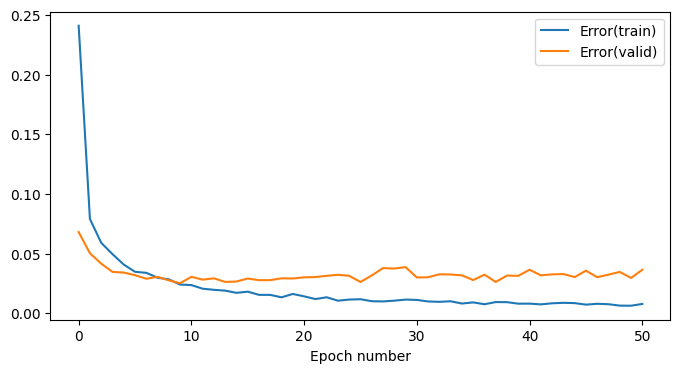

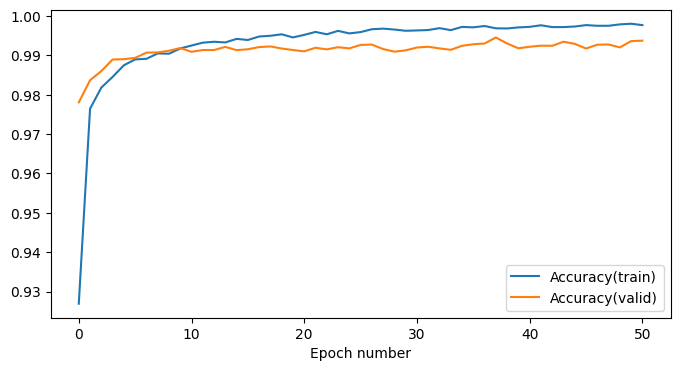

In [7]:
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(train_loss, label='Error(train)')
ax_1.plot(valid_loss, label='Error(valid)')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
ax_2.plot(train_acc, label='Accuracy(train)')
ax_2.plot(valid_acc, label='Accuracy(valid)')
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
plt.show()

Convolutional Neural Networks achieve better performance than Multi-Layer Perceptrons on image datasets. This is because they are able to capture the spatial structure of the data. Compare the results obtained in this lab with those obtained in the lab 3, which introduced multiple-layer models.

In [8]:
# Testing
test_acc = []
model.eval()
for batch_idx, (x, t) in enumerate(test_loader):
    x = x.to(device)
    t = t.to(device)

    # Forward pass
    y = model(x)
    
    # Calculate accuracy
    _, argmax = torch.max(y, 1)
    acc = (t == argmax.squeeze()).float().mean()
    
    test_acc.append(acc.item())
test_acc = np.mean(test_acc)
print('Accuracy(test): {:.6f}'.format(test_acc))

Accuracy(test): 0.993671
